In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import glob

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
path = "data/"
img_folder = "images_train"
label_file = "y_train.csv"
seed = 0

In [3]:
labels = pd.read_csv("{}{}".format(path, label_file))
possible_labels = pd.unique(labels["cell_line"])
print(possible_labels)
labels.head()

['MCF7' 'RT4' 'U-2 OS' 'A549' 'HEK 293' 'CACO-2' 'PC-3' 'HeLa' 'U-251 MG']


,file_id,cell_line
0,1,MCF7
1,2,RT4
2,3,U-2 OS
3,4,RT4
4,5,A549


A549: 608
CACO-2: 1626
HEK 293: 1378
HeLa: 632
MCF7: 1082
PC-3: 663
RT4: 2100
U-2 OS: 775
U-251 MG: 768


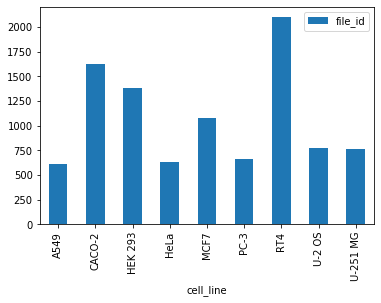

In [11]:
def plot_label_dist(df):
    df.groupby("cell_line").agg(pd.Series.nunique).plot(kind="bar")
    for label, data in df.groupby("cell_line"):
        print(f"{label}: {len(data)}")
plot_label_dist(labels)

In [8]:
images = []
rgb = []
count = 0
for f in glob.iglob(f"{path}{img_folder}/*"):
    rgb.append(np.asarray(Image.open(f)))
    if len(rgb) == 3:
        count += 1
        if count % 1000 == 0:
            print(f"Added Image {count}")
        images.append(np.dstack(rgb))
        rgb = []

images = np.array(images)

Added Image 1000
Added Image 2000
Added Image 3000
Added Image 4000
Added Image 5000
Added Image 6000
Added Image 7000
Added Image 8000
Added Image 9000


In [9]:
images.shape

(9632, 64, 64, 3)

,file_id,cell_line
7674,7675,HeLa
6450,6451,HeLa
2016,2017,RT4
2529,2530,RT4
7736,7737,MCF7


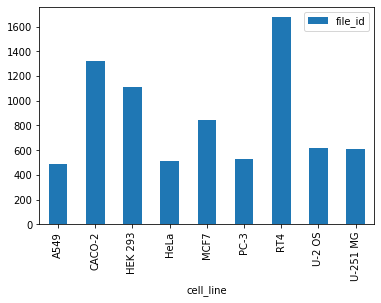

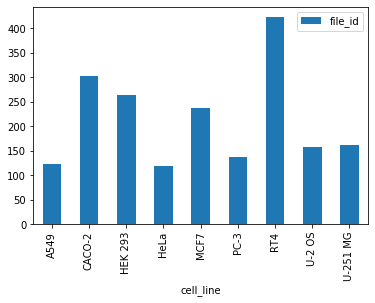

In [10]:
X_train, X_val = train_test_split(labels, test_size=0.2, random_state=seed)
plot_label_dist(X_train)
plot_label_dist(X_val)
X_train.head()

In [11]:
for i in range(images.shape[3]):
        mean = np.mean(images[:,:,:,i]/255)
        std = np.std(images[:,:,:,i]/255)
        print(f"Dimension {i} - Mean: {mean} - Std: {std}")
for data in [X_train, X_val]:
    img_data = images[data["file_id"] - 1]/255
    print(len(data))
    for i in range(img_data.shape[3]):
        mean = np.mean(img_data[:,:,:,i])
        std = np.std(img_data[:,:,:,i])
        print(f"Dimension {i} - Mean: {mean} - Std: {std}")

Dimension 0 - Mean: 0.129141800436676 - Std: 0.22157370246519384
Dimension 1 - Mean: 0.13188854319662113 - Std: 0.16498469452959977
Dimension 2 - Mean: 0.1470356933084826 - Std: 0.15918220919249032
7705
Dimension 0 - Mean: 0.12924168581743625 - Std: 0.22172751498717305
Dimension 1 - Mean: 0.13177942558228667 - Std: 0.16479915192974112
Dimension 2 - Mean: 0.14697112699669063 - Std: 0.15907541166091207
1927
Dimension 0 - Mean: 0.12874241441760287 - Std: 0.2209571706498563
Dimension 1 - Mean: 0.13232484377702827 - Std: 0.16572378227451243
Dimension 2 - Mean: 0.14729385803726358 - Std: 0.1596082579435951


In [12]:
for l in possible_labels:
    Path(f"{path}train/{l}").mkdir(parents=True, exist_ok=True)
    Path(f"{path}val/{l}").mkdir(parents=True, exist_ok=True)
    Path(f"{path}train_balanced/{l}").mkdir(parents=True, exist_ok=True)
    Path(f"{path}val_balanced/{l}").mkdir(parents=True, exist_ok=True)
    Path(f"{path}train_all/{l}").mkdir(parents=True, exist_ok=True)
    
def save_images(df, images, path):
    for x in df.values:
        index = x[0]
        im = Image.fromarray(images[index - 1])
        im.save(f"{path}/{x[1]}/{index:04}.png")

In [13]:
save_images(X_train, images, f"{path}train")
save_images(X_val, images, f"{path}val")

In [14]:
im = Image.open(f"{path}train/MCF7/0001.png")
imnp = np.array(im)
print(imnp.shape)
#Check if saved image can easily be loaded and is the same
(imnp == images[0]).all()

(64, 64, 3)


True

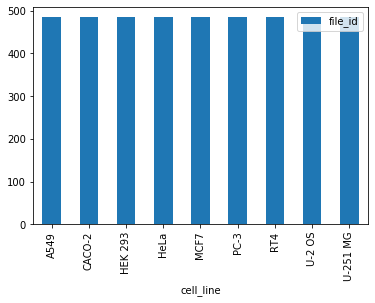

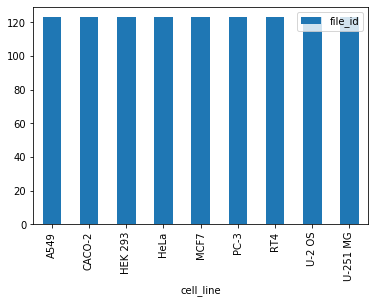

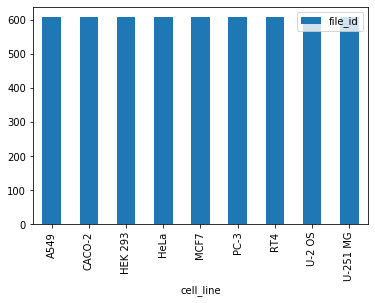

In [15]:
def balance_df(df):
    groups = df.groupby("cell_line")
    i = groups.agg(pd.Series.nunique).min()["file_id"]
    balanced = []
    leftovers = []
    for col, group in groups:
        balanced.append(group[0:i])
        leftovers.append(group[i:])
    return pd.concat(balanced), pd.concat(leftovers)
    
X_train_balanced, leftovers = balance_df(X_train)
X_val_balanced, _ = balance_df(pd.concat([X_val, leftovers]))
X_balanced = pd.concat([X_train_balanced, X_val_balanced])
plot_label_dist(X_train_balanced)
plot_label_dist(X_val_balanced)
plot_label_dist(X_balanced)

In [16]:
save_images(X_train_balanced, images, f"{path}train_balanced")
print("Finished Saving Training Data")
save_images(X_val_balanced, images, f"{path}val_balanced")
print("Finished Saving Validation Data")
save_images(X_balanced, images, f"{path}train_all")
print("Finished Saving All Training Data")

Finished Saving Training Data
Finished Saving Validation Data
Finished Saving All Training Data


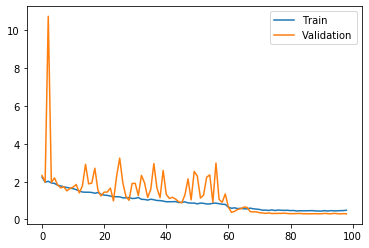

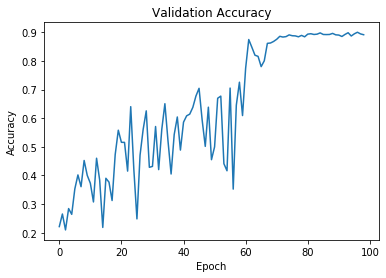

97
0.9007218567251462
0.2947233137157228
0.46831582076307654
97
0.9007218567251462
0.2947233137157228
0.46831582076307654


In [13]:
loss_train = [2.2393904993499536, 1.973483493362648, 2.020961626716282, 1.9324899341749109, 1.90962897349095, 1.8139842662258425, 1.7751323762147322, 1.7273680230845576, 1.6956638270530149, 1.6595690682314443, 1.630536739377008, 1.5781350757764734, 1.508464218913645, 1.4519378707028818, 1.4421367351559624, 1.44227997980256, 1.4294745542001033, 1.3868946700856306, 1.4254589063533838, 1.335126897563105, 1.2890955607096355, 1.2749844754951587, 1.238604359868644, 1.2064465189325637, 1.2034153990123584, 1.1983970947887586, 1.1450339538463647, 1.1428278857383176, 1.1626381684040679, 1.1104205924531687, 1.118271705896958, 1.1625368137290513, 1.0666838098263396, 1.0598272370255513, 1.0257460690926814, 1.0719585643298384, 1.0438486881878064, 1.0035358399584673, 1.001404050467671, 0.9734818538029989, 0.9390292694603187, 0.9397920629252559, 0.9407941137534984, 0.9472377628519915, 0.8968819829000942, 0.9055205764977828, 0.9321105920750162, 0.8784332093985184, 0.8676863511403402, 0.8676666841990706, 0.8278630298116932, 0.8674088871997335, 0.8556846406148828, 0.8203679202259451, 0.8234724661578303, 0.8553904947163402, 0.8668283172275709, 0.8327635919702225, 0.8077669506487639, 0.796537036481111, 0.6544693790484166, 0.5920504668484563, 0.6164909462997878, 0.5762255291144053, 0.5913161605164625, 0.5666548804096554, 0.5613921129185221, 0.6011350522006768, 0.5665681396705516, 0.549682816301567, 0.5307241773259812, 0.48923779613729834, 0.4964705619259157, 0.47852976382642554, 0.5077543746734011, 0.47554673686407617, 0.500299434730972, 0.4872093649878018, 0.48309326646984485, 0.4874784194904825, 0.4695249184750129, 0.47548285990521527, 0.44737871077613556, 0.464507012695506, 0.45869679749011993, 0.45921950646932574, 0.4643426753472591, 0.47055465630863025, 0.45324083968349127, 0.4470108147116675, 0.4455323314321214, 0.4701909589162771, 0.44269908575907996, 0.4698380663775016, 0.456750996734785, 0.45736739125804626, 0.46831582076307654, 0.4700695176919301, 0.488271486715994]
plt.plot(loss_train, label="Train")
loss_val = [2.3246008356412253, 1.9786017205980089, 10.74810536702474, 1.9557946589257982, 2.198731117778354, 1.8319115108913846, 1.6747215655114915, 1.7368380493587918, 1.513644854227702, 1.6390931341383193, 1.709777381685045, 1.8514570328924391, 1.4077474077542622, 1.779635316795773, 2.917949848704868, 1.88448742363188, 1.921884576479594, 2.7108898560206094, 1.5436257123947144, 1.2463826106654272, 1.4469037387106154, 1.449254314104716, 1.661657578415341, 0.9837651352087656, 2.2762291895018683, 3.2449080546696982, 1.950726376639472, 1.2298379871580336, 1.0144288705454931, 1.9037414524290297, 1.9119637807210286, 1.27146119872729, 2.331748021973504, 1.9380900661150615, 1.1656724545690749, 1.5871782236629062, 2.9557455513212414, 1.6602243979771931, 1.1587027543120914, 2.590982642438677, 1.3267802861001756, 1.1124373873074849, 1.1736158662372165, 1.0800043212042914, 0.9372151096661886, 0.8848089310857985, 1.2961652179559071, 2.1471805771191916, 1.0372143685817719, 2.5409738222757974, 2.29192316532135, 1.132807172007031, 1.2858171628581152, 2.23634445004993, 2.3583366539743214, 0.9094571239418454, 2.9850984149509006, 1.061419152551227, 0.9082541730668809, 1.3514308498965368, 0.6530850330988566, 0.37820052521096337, 0.43049922916624284, 0.5360566245185004, 0.5666928423775567, 0.6555399348338445, 0.6405618439118067, 0.4184344145986769, 0.40055472320980495, 0.40641656186845565, 0.35881136109431583, 0.3455241380466355, 0.3237777575850487, 0.3455988172855642, 0.3167034197184775, 0.32000967032379574, 0.32502767112520004, 0.3232337277796533, 0.3338831166426341, 0.31692977911896175, 0.30688673588964677, 0.30972163875897724, 0.31396614470415646, 0.3209827658202913, 0.30374328792095184, 0.30357517177859944, 0.2996903248131275, 0.30484330157438916, 0.305299785402086, 0.3022380636798011, 0.30331650334927773, 0.32150450845559436, 0.30908213390244377, 0.29978136635488933, 0.32347798513041603, 0.3095037084486749, 0.2947233137157228, 0.3098665277163188, 0.2997823825312985]
plt.plot(loss_val, label="Validation")
plt.legend()
plt.show()
acc = [0.22121710526315788, 0.2652595029239766, 0.2096125730994152, 0.28426535087719296, 0.2640716374269006, 0.3529331140350877, 0.4018640350877193, 0.3607456140350877, 0.45234831871345027, 0.4003563596491228, 0.37266995614035087, 0.30738304093567254, 0.4602521929824561, 0.3838633040935673, 0.21829312865497075, 0.39016812865497075, 0.3766904239766082, 0.3123629385964912, 0.4730445906432748, 0.5582054093567251, 0.5158991228070176, 0.5156706871345029, 0.41520467836257313, 0.6405336257309941, 0.4215095029239766, 0.24812682748538015, 0.4707602339181286, 0.5608095760233919, 0.6258223684210527, 0.428453947368421, 0.43169773391812866, 0.5711348684210527, 0.42041301169590645, 0.5612207602339181, 0.6508589181286549, 0.5211074561403508, 0.40510782163742687, 0.5431286549707602, 0.6044407894736842, 0.4887609649122807, 0.5863029970760234, 0.6084612573099415, 0.6144005847953217, 0.638157894736842, 0.6777686403508771, 0.7046783625730995, 0.5937956871345029, 0.5016904239766081, 0.6387061403508771, 0.4551352339181286, 0.4999543128654971, 0.6699561403508771, 0.6774488304093568, 0.4411549707602339, 0.41639254385964913, 0.7055464181286549, 0.3522934941520468, 0.6458790204678363, 0.7260599415204678, 0.6094206871345029, 0.7749908625730995, 0.8752284356725146, 0.8483187134502924, 0.8204495614035088, 0.8164290935672515, 0.7805190058479532, 0.8008040935672515, 0.8618877923976608, 0.8630756578947368, 0.8685124269005847, 0.8760964912280702, 0.8865131578947368, 0.8839089912280702, 0.8854166666666666, 0.8914930555555556, 0.8885690789473685, 0.8879294590643274, 0.8847770467836258, 0.8896655701754386, 0.8847770467836258, 0.8940972222222222, 0.8955135233918128, 0.8929093567251462, 0.8940058479532164, 0.8984375, 0.8929093567251462, 0.8925895467836258, 0.8929093567251462, 0.8967013888888888, 0.8917214912280702, 0.8908534356725146, 0.8858735380116959, 0.8931377923976608, 0.898985745614035, 0.8876096491228069, 0.8951937134502924, 0.9007218567251462, 0.8948739035087718, 0.8920413011695906]
plt.plot(acc, label="validation accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
print(np.argmin(loss_val) + 1)
print(acc[np.argmin(loss_val)])
print(loss_val[np.argmin(loss_val)])
print(loss_train[np.argmin(loss_val)])
print(np.argmax(acc) + 1)
print(acc[np.argmax(acc)])
print(loss_val[np.argmax(acc)])
print(loss_train[np.argmax(acc)])